# GRU4Rec

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import OrderedDict
import pandas as pd
import numpy as np
from recs.evaluator import metrics, evaluate
from recs import utils
from recs.jaxmodels import gru4rec, GRU4RecConfig
from recs.dataset import session_parallel_dataset
import jax

import matplotlib.pyplot as plt
import japanize_matplotlib


In [7]:
data = pd.read_pickle("~/work/dataset/diginetica2/derived/train.df")
testdata = pd.read_pickle("~/work/dataset/diginetica2/derived/test.df")

In [8]:
num_items = max(data.itemId.max(), testdata.itemId.max()) + 1
config = GRU4RecConfig(
    hidden_size=100, 
    output_size=num_items, 
    batch_size=500, 
    dropout_hidden=0., 
    learning_rate=0.01, 
    final_act="log_softmax",
    num_epochs=100,
    early_stop_count=3
)

In [9]:
train_data, total_length = session_parallel_dataset(
    path="~/work/dataset/diginetica2/derived/train.df",
    batch_size = config.batch_size,
    issort=False,
    timekey="eventdate"
)

In [12]:
state, hidden, model = gru4rec.create_train_state(jax.random.PRNGKey(0), config)

In [19]:
state, hidden, loss = gru4rec.train(
    config,
    model,
    state,
    train_data,
    total_length,
    hidden=hidden
)

[Epoch 50] training: 100%|████| 843/843 [00:06<00:00, 123.11it/s, loss=1.123653]


In [20]:
test_data, test_len = session_parallel_dataset(
    path="~/work/dataset/diginetica2/derived/test.df", 
    batch_size=config.batch_size, 
    issort=False,
    timekey="eventdate"
)

In [21]:
pred_df = gru4rec.predict(
    config,
    model,
    state,
    test_data,
    test_len,
)

predicting: 100%|████████████████████████████▉| 286/287 [00:11<00:00, 24.14it/s]


In [36]:
evals, eval_scores = evaluate.evaluate(
    pred_df,
    k=20
)

In [37]:
evals

,precision,map,recall,ndcg,mrr
0,0.00,0.00000,0.0,0.000000,0.000000
1,0.00,0.00000,0.0,0.000000,0.000000
2,0.00,0.00000,0.0,0.000000,0.000000
3,0.05,0.06572,1.0,0.050596,0.166667
4,0.00,0.00000,0.0,0.000000,0.000000
...,...,...,...,...,...
495,0.00,0.00000,0.0,0.000000,0.000000
496,0.00,0.00000,0.0,0.000000,0.000000
497,0.00,0.00000,0.0,0.000000,0.000000
498,0.00,0.00000,0.0,0.000000,0.000000


In [45]:
from tqdm import tqdm
eval_score_df = pd.DataFrame(
    columns=["precision", "map", "recall", "ndcg", "mrr"]
)
for k in tqdm(np.arange(5, 40, 5)):
    _, eval_scores = evaluate.evaluate(
    pred_df,
    k=k)
    eval_score_df = pd.concat([
        eval_score_df,
        pd.DataFrame(eval_scores, columns=[k]).T
    ], axis=0)

100%|█████████████████████████████████████████████| 7/7 [02:57<00:00, 25.41s/it]


In [50]:
eval_score_df = eval_score_df.reset_index().rename({"index":"k"}, axis=1)

In [51]:
eval_score_df

,k,precision,map,recall,ndcg,mrr
0,5,0.017357,0.021108,0.086783,0.019256,0.046955
1,10,0.01315,0.017842,0.131497,0.015662,0.052852
2,15,0.010814,0.01578,0.162203,0.013526,0.055265
3,20,0.00931,0.014302,0.186196,0.012066,0.056613
4,25,0.008225,0.013167,0.205636,0.010969,0.057463
5,30,0.007407,0.012258,0.22221,0.010108,0.058057
6,35,0.006755,0.011507,0.236441,0.009405,0.058489


<AxesSubplot:>

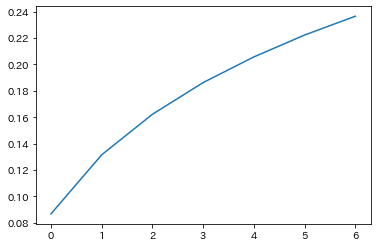

In [65]:
eval_score_df["recall"].plot()

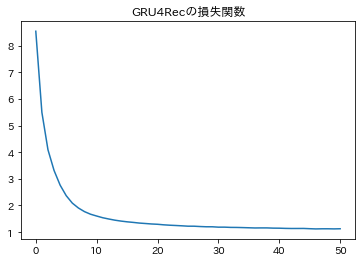

In [33]:
plt.plot(loss)
plt.title("GRU4Recの損失関数")
plt.show()